In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

plt.style.use("ggplot")

print(tf.test.is_built_with_cuda())
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

True
Num GPUs Available:  1


In [2]:
RECORDS_PATH = "../data/records"
TRAIN_FILENAMES = tf.io.gfile.glob(RECORDS_PATH + "/train/train_*.tfrecord")
VAL_FILENAMES = tf.io.gfile.glob(RECORDS_PATH + "/val/val_*.tfrecord")
VISUAL_FILENAMES = ["../data/records/visual.tfrecord"]

print(f"Number of training files: {len(TRAIN_FILENAMES)}")
print(f"Number of validation files: {len(VAL_FILENAMES)}")

Number of training files: 102
Number of validation files: 13


In [3]:
EMBEDDING_DIM = 16
JUDGMENT_DIM = 4
BEATMAP_CONTEXT_DIM = 8

FEATURE_DESCRIPTION = {
    "embeddings": tf.io.VarLenFeature(dtype = tf.float32),
    "judgments": tf.io.VarLenFeature(dtype = tf.int64),
    "beatmap_context": tf.io.FixedLenFeature([8], dtype = tf.float32),
    "replay_length": tf.io.FixedLenFeature([], dtype = tf.int64),
}

### Build TF Dataset Loader

In [4]:
NOTES_PER_EXAMPLE = 64
NOTES_PER_REPLAY = 256


@tf.function
def get_embedding_sequence(embeddings, judgments, replay_len, note_idx):
    
    embs = None
    judgs = None
    
    # hide last judgment
    if replay_len - note_idx - NOTES_PER_EXAMPLE >= 0:
        embs = embeddings[ replay_len - note_idx - NOTES_PER_EXAMPLE : replay_len - note_idx , : ]
        judgs = judgments[ replay_len - note_idx - NOTES_PER_EXAMPLE : replay_len - note_idx - 1, : ]     
    else:
        embs = embeddings[ 0 : replay_len - note_idx , : ]  
        judgs = judgments[ 0 : replay_len - note_idx - 1 , : ]
    
    judgs = tf.concat([judgs, tf.zeros([1, JUDGMENT_DIM])], axis = 0)


    return tf.concat([embs, judgs], axis = 1)


def reformat_example(example):

    feature_tensor_slices = []
    label_tensor_slices = []

    replay_len = example["replay_length"]
    embeddings = tf.reshape( example["embeddings"].values, [replay_len, EMBEDDING_DIM])
    judgments  = tf.reshape( example["judgments"].values, [replay_len, JUDGMENT_DIM])
    judgments = tf.cast(judgments, tf.float32)
    beatmap_context = tf.reshape( example["beatmap_context"], [1, BEATMAP_CONTEXT_DIM ] )
     
    for note_idx in range(NOTES_PER_REPLAY):
        
        embedding_sequence = get_embedding_sequence(embeddings, judgments, replay_len, note_idx)
        context_sequence = tf.tile(beatmap_context, [len(embedding_sequence), 1])
        
        sequence = tf.concat([embedding_sequence, context_sequence], axis = 1)       
        padding = tf.zeros(shape = [NOTES_PER_EXAMPLE - len(embedding_sequence), EMBEDDING_DIM + BEATMAP_CONTEXT_DIM + JUDGMENT_DIM])

        feature_tensor_slices.append(
                tf.concat([padding, sequence], axis = 0)
        )
        label_tensor_slices.append(
            tf.reshape(judgments[replay_len - note_idx - 1, :], [JUDGMENT_DIM,])
        )
    
    feature_dataset = tf.data.Dataset.from_tensor_slices(feature_tensor_slices)
    label_dataset =  tf.data.Dataset.from_tensor_slices(label_tensor_slices)
    
    return tf.data.Dataset.zip((feature_dataset, label_dataset))


def filter_example_len(example):
    return tf.greater_equal(example["replay_length"], NOTES_PER_REPLAY)
         

def parse_example(raw_data):
    example_obj = tf.io.parse_single_example(raw_data, FEATURE_DESCRIPTION)
    return example_obj


In [5]:
BATCH_SIZE = 1024
SHUFFLE_BUFFER_SIZE = 4096

def load_dataset(filenames):

    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False  # disable order, increase speed

    dataset = tf.data.TFRecordDataset(
        filenames,
        compression_type = "ZLIB"
    ) 

    dataset = dataset.with_options(
        ignore_order
    ) 

    dataset = dataset.map(
        parse_example, num_parallel_calls = tf.data.AUTOTUNE
    )

    return dataset


def get_dataset(filenames):

    dataset = load_dataset(filenames)
    dataset = dataset.filter(filter_example_len)
    dataset = dataset.flat_map(reformat_example)
    dataset = dataset.shuffle(SHUFFLE_BUFFER_SIZE, reshuffle_each_iteration = True)
    dataset = dataset.prefetch(buffer_size = tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE)

    return dataset

In [7]:
data = get_dataset(TRAIN_FILENAMES)

In [8]:
for b in data:
    print(b[0][0], b[1][0])
    break

tf.Tensor(
[[ 416.  252.  320. ...  130.    0.    0.]
 [ 107.  283. -309. ...  130.    0.    0.]
 [ 404.  100.  297. ...  130.    0.    0.]
 ...
 [ 348.  264.   56. ...  130.    0.    0.]
 [ 392.  220.   44. ...  130.    0.    0.]
 [ 392.  220.    0. ...  130.    0.    0.]], shape=(64, 28), dtype=float32) tf.Tensor([1. 0. 0. 0.], shape=(4,), dtype=float32)


In [17]:
batch_count = 0
for batch in data:
    batch_count += 1
batch_count

179911

### Do Grid Search

In [9]:
def build_sequential_model(num_lstm_layers, lstm_layer_size, num_hidden_layers, hidden_layer_size):
    
    
    inputs = tf.keras.layers.Input(shape = [NOTES_PER_EXAMPLE, EMBEDDING_DIM + BEATMAP_CONTEXT_DIM + JUDGMENT_DIM], name = "input")
    
    
    x = tf.keras.layers.LSTM(lstm_layer_size, return_sequences = bool(num_lstm_layers > 1), name = "lstm_0")(inputs)
    for i in range(1, num_lstm_layers):
        if i == num_lstm_layers - 1:
            x = tf.keras.layers.LSTM(lstm_layer_size, name = f"lstm_{i}")(x)
        else:
            x = tf.keras.layers.LSTM(lstm_layer_size, return_sequences = True, name = f"lstm_{i}")(x)
    
    
    x = tf.keras.layers.Dense(hidden_layer_size, activation = "relu", name = "hidden_0")(x)
    for i in range(1, num_hidden_layers):
        x = tf.keras.layers.Dense(hidden_layer_size, activation = "relu", name = f"hidden_{i}")(x)


    outputs = tf.keras.layers.Dense(JUDGMENT_DIM, activation = "softmax", name = "output_layer")(x)

    model = tf.keras.Model(inputs = inputs, outputs = outputs, name = f"{num_lstm_layers}_{lstm_layer_size}_{num_hidden_layers}_{hidden_layer_size}")

    return model


def get_lr_schedule(init_learning_rate, decay_step_count):
    return tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate = init_learning_rate, decay_steps = decay_step_count, decay_rate = 0.96, staircase = True
    )
    
def get_optimizer(idx):
    if idx == 0:
        return tf.keras.optimizers.Adam()
    if idx == 1:
        return tf.keras.optimizers.Adam(learning_rate = get_lr_schedule(0.001, 1000))
    if idx == 2:
        return tf.keras.optimizers.Adam(clipnorm = 1, learning_rate = get_lr_schedule(0.001, 1000))
    

In [11]:
lstm_layer_counts = [1, 2, 3]
lstm_layer_sizes = [128, 256]
hidden_layer_counts = [4, 5]
hidden_layer_sizes = [512]


NUM_EPOCHS = 1

histories = []

for lstm_layer_count in lstm_layer_counts:
    for lstm_layer_size in lstm_layer_sizes:
        for hidden_layer_count in hidden_layer_counts:
            for hidden_layer_size in hidden_layer_sizes:
                        
                    print(f"\n\nTraining model {(lstm_layer_count, lstm_layer_size, hidden_layer_count, hidden_layer_size)}\n")
                    
                    model = build_sequential_model(
                        num_lstm_layers = lstm_layer_count, 
                        lstm_layer_size = lstm_layer_size,
                        num_hidden_layers = hidden_layer_count,
                        hidden_layer_size = hidden_layer_size, 
                    )
                    
                    opt = get_optimizer(1)
                    
                    model.compile(
                        optimizer = opt,
                        loss = "categorical_crossentropy",
                        metrics = [
                            tf.keras.metrics.CategoricalAccuracy(name = "categorical_acc")
                        ]
                    )
                    
                    train_dataset = get_dataset(TRAIN_FILENAMES)
                    val_dataset = get_dataset(VAL_FILENAMES)
                    
                    history = model.fit(
                        
                        train_dataset,
                        epochs = NUM_EPOCHS,    
                        validation_data = val_dataset,
                        
                    )
                    
                    model.save(f"seq_{lstm_layer_count}_{lstm_layer_size}_{hidden_layer_count}_{hidden_layer_size}.keras")
                    
                    histories.append([
                        lstm_layer_count, lstm_layer_size, hidden_layer_count, hidden_layer_size, 
                        history.history["loss"], history.history["categorical_acc"], 
                        history.history["val_loss"], history.history["val_categorical_acc"]
                    ])



Training model (1, 128, 4, 512)

44978/44978 [==============================] - 2590s 57ms/step - loss: 0.2763 - categorical_acc: 0.9146 - val_loss: 0.2603 - val_categorical_acc: 0.9177


Training model (1, 128, 5, 512)

44978/44978 [==============================] - 2595s 57ms/step - loss: 0.2795 - categorical_acc: 0.9146 - val_loss: 0.2682 - val_categorical_acc: 0.9163


Training model (1, 256, 4, 512)

44978/44978 [==============================] - 2644s 59ms/step - loss: 0.2723 - categorical_acc: 0.9157 - val_loss: 0.2555 - val_categorical_acc: 0.9184


Training model (1, 256, 5, 512)

44978/44978 [==============================] - 2535s 56ms/step - loss: 0.2669 - categorical_acc: 0.9158 - val_loss: 0.2530 - val_categorical_acc: 0.9182


Training model (2, 128, 4, 512)

44978/44978 [==============================] - 2610s 58ms/step - loss: 0.2506 - categorical_acc: 0.9199 - val_loss: 0.2428 - val_categorical_acc: 0.9215


Training model (2, 128, 5, 512)

44978/44978 [============

### Train Final Model

In [26]:
FINAL_LSTM_LAYER_COUNT = 3
FINAL_LSTM_LAYER_SIZE = 128
FINAL_LAYER_COUNT = 4
FINAL_LAYER_SIZE = 512
FINAL_OPT_IDX = 1
FINAL_NUM_EPOCHS = 2


model = build_sequential_model(
    num_lstm_layers = FINAL_LSTM_LAYER_COUNT,
    lstm_layer_size = FINAL_LSTM_LAYER_SIZE,
    num_hidden_layers = FINAL_LAYER_COUNT,
    hidden_layer_size = FINAL_LAYER_SIZE,
)

opt = get_optimizer(FINAL_OPT_IDX)

model.compile(
    optimizer = opt,
    loss = "categorical_crossentropy",
    metrics = [
        tf.keras.metrics.CategoricalAccuracy(name = "categorical_acc")
    ]
)

train_dataset = get_dataset(TRAIN_FILENAMES)
val_dataset = get_dataset(VAL_FILENAMES)

history = model.fit(
    
    train_dataset,
    epochs = FINAL_NUM_EPOCHS,
    validation_data = val_dataset,
    
)

In [24]:
model.save(f"seq_final.keras")

### Visualize Performance

In [7]:
MODEL_PATH = "../models/seq2seq/seq2seq_final.keras"
model = tf.keras.models.load_model(MODEL_PATH)

In [12]:
BATCH_SIZE = 1024

context_labels = [
    "ar",
    "circle_radius",
    "hp",
    "hitwindow_300",
    "hitwindow_100",
    "hitwindow_50",
    "hd",
    "dt",
]

emb_labels = [
    "x_pos",
    "y_pos",
    "in_x_offset",
    "in_y_offset",
    "in_dist",
    "in_timedelta",
    "out_x_offset",
    "out_y_offset",
    "out_dist",
    "out_timedelta",
    "angle",
    "is_slider",
    "slider_duration",
    "slider_length",
    "slider_num_ticks",
    "slider_num_beats"
]

true_labels = [
    "300",
    "100",
    "50",
    "miss"
]

prob_labels = [
    "p_300",
    "p_100",
    "p_50",
    "p_miss"
]

val_dataset = get_dataset(VAL_FILENAMES)
features, labels = next(iter(val_dataset))
probs = model.predict_on_batch(features)

notes_df = pd.DataFrame(
    np.concatenate(
        (features[:, -1, :], labels, probs), 
        axis = 1
    ), columns = emb_labels + true_labels + context_labels + true_labels + prob_labels
)

print(len(notes_df))
notes_df.head()

1024


,x_pos,y_pos,in_x_offset,in_y_offset,in_dist,in_timedelta,out_x_offset,out_y_offset,out_dist,out_timedelta,...,hd,dt,300,100,50,miss,p_300,p_100,p_50,p_miss
0,466.00000,83.00000,-16.000,-84.000,85.510231,119.0,-284.000,11.000,284.212952,238.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.991812,2.224705e-08,2.402539e-09,0.008188
1,402.00000,221.00000,148.000,-116.000,188.042542,231.0,-259.000,-205.000,330.311981,231.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.992338,2.083058e-09,1.938041e-10,0.007662
2,303.00000,335.00000,-29.000,134.000,137.102158,806.0,-98.000,-42.000,106.620827,161.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.970110,2.813310e-02,2.722639e-04,0.001485
3,284.35199,300.35199,3.648,3.648,5.159051,79.0,3.648,3.648,5.159051,79.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.965289,3.381201e-02,6.691869e-04,0.000230
4,86.00000,176.00000,-113.000,56.000,126.115028,429.0,0.000,0.000,0.000000,143.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.912411,8.197097e-02,2.681663e-03,0.002937


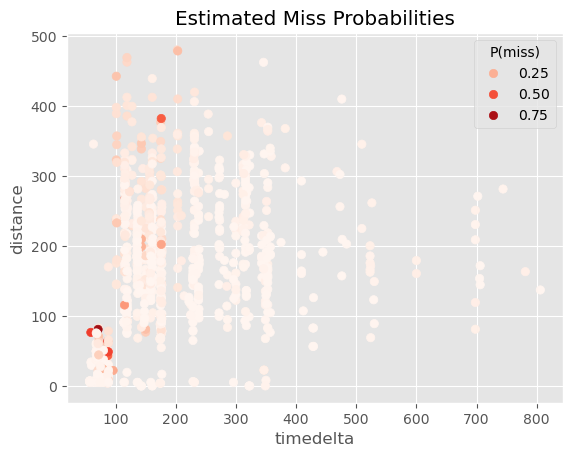

In [13]:
fig, ax = plt.subplots()

plt.title("Estimated Miss Probabilities")

scatter = ax.scatter("in_timedelta", "in_dist", c = "p_miss", cmap = "Reds", data = notes_df)
ax.set_xlabel("timedelta")
ax.set_ylabel("distance")

legend1 = ax.legend(*scatter.legend_elements(num = 4), title = "P(miss)")


### Evaluate on Test Dataset

In [8]:
TEST_FILENAMES = tf.io.gfile.glob(RECORDS_PATH + "/test/test_*.tfrecord")

test_dataset = get_dataset(TEST_FILENAMES)

model.evaluate(test_dataset)

5783/5783 [==============================] - 360s 59ms/step - loss: 0.2381 - categorical_acc: 0.9232


[0.23812814056873322, 0.9232453107833862]